Bandpass_optimization
=====================



## Three-layer half-wave plate polarization angle dependence



(Half-wave plate phase variation code adapted from code by Jeff McMahon)



In [1]:
import hwp_optimizer as hwp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['figure.figsize'] = (4, 3)
matplotlib.rcParams['axes.grid'] = True

In [2]:
def get_phase_diffs(wavelengths, no=3.05, ne=3.35, hwp_thickness=3.95,
                    thetas=(0, 58*np.pi/180, 0), debug=False):
    '''
    # hwp_thickness --- the thickness of each layer, use mm
    # theta --- the angle of the ordinary axis relative to the x axis
    # no    --- the index along the ordinary axis
    # ne    --- the index along the extrodinary axis
    # wavelength  --- the wavelenght, use mm
    '''

    ## fiducial SO design
    # no = 3.05
    # ne = 3.35
    # thick_HWP = 3.96 #was 3.95
    epsi = 0
    angle = 28.5
    delta = 0
    eta = 0.

    ## numer of angles to use in the simulations of the HWP
    n_angles = 32

    ## three stack, standard
    thicks = np.array([hwp_thickness] * len(thetas))
    #thetas = np.array([0,58*np.pi/180.,0])
    #print(thick_HWP)

    mod_effs = np.zeros(np.shape(wavelengths))
    phases = np.zeros(np.shape(wavelengths))


    ## make the transfer funciton
    i = 0
    while (i < np.size(wavelengths)):
        wavelength = wavelengths[i]
        TF = hwp.make_HWP_transfer_matrix(thicks, np.array(thetas),
                                          no, ne, wavelengths[i])
        angs,Exo,Eyo = hwp.sim_rot_HWP(TF,n_angles)
        mod_eff,phase = hwp.mod_eff_and_phase(Exo)
        mod_effs[i] = mod_eff
        phases[i] = phase
        i +=1

    if (debug):
        print(np.mean(mod_effs[np.where(np.logical_and(freq_GHZ>75,freq_GHZ<112))]))
        print(np.mean(mod_effs[np.where(np.logical_and(freq_GHZ>122,freq_GHZ<170))]))

    return freq_GHZ, phases
    #new_phases = phases - np.mean(phases[70:170])

## setup the sim
freq_GHZ = np.arange(60, 200, 1)  ## from 60 to 200 GHz
wavelengths = 1./freq_GHZ *300.  ## convert to mm
freqs, half_wave_plate_phases = get_phase_diffs(wavelengths)

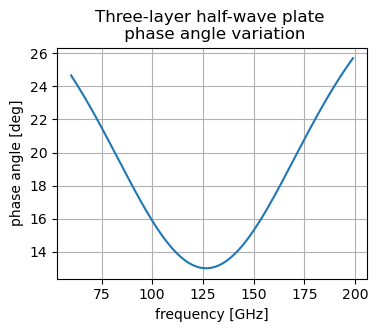

In [3]:
plt.plot(freqs, half_wave_plate_phases)
plt.xlabel('frequency [GHz]')
plt.ylabel('phase angle [deg]')
plt.title('Three-layer half-wave plate \n phase angle variation')
plt.show()

## Realistic detector passbands



Currently I just read in simulated v3r7 LATRt bands from the bolocalc model
(Carlos). We don&rsquo;t have realistic bandpass measurements of the SAT yet so I&rsquo;m
not sure how much better we could do for these. But maybe ask Carlos if there
are any better ones if you really want to be accurate.



In [4]:
mf1_data = np.loadtxt('MF_1.txt')
mf2_data = np.loadtxt('MF_2.txt')

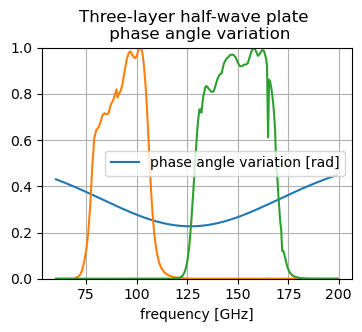

In [5]:
plt.plot(freqs, np.deg2rad(half_wave_plate_phases), label='phase angle variation [rad]')
plt.plot(mf1_data[:, 0], mf1_data[:, 1])
plt.plot(mf2_data[:, 0], mf2_data[:, 1])
plt.ylim(0, 1)
plt.xlabel('frequency [GHz]')
plt.title('Three-layer half-wave plate \n phase angle variation')
plt.legend()
plt.show()

## Integrate phase angle variation over the passband



The frequency-dependent phase variation $\phi(\nu)$ will have different effects
for different sources. The averaged phase angle variation integrated over the
passband $\tau(\nu)$ for a source with frequency dependence $f(\nu)$ can be found by
computing

$$\frac{\int \tau(\nu) \phi(\nu) f(\nu)\, d\nu}{\int \tau(\nu) f(\nu)\, d\nu}$$

For instance, the band-averaged polarization angle variation for a
frequency-independent source reduces to the usual computation

$$\frac{\int \tau(\nu) \phi(\nu) \, d\nu}{\int \tau(\nu) \, d\nu}$$



In [6]:
def propagate_center_uncertainty(
        bandpass_center_shift, passband_function, phase_angle_function, freqs,
        integration_function=lambda x: x):
    '''Find change in integrated phase with a shift in the bandpass center

    Find

    parameters:

    bandpass_center_shift       - shift in GHz of the center of the bandpasss
                                  region

    passband_function           - passband function tau(nu) which returns the
                                  normalized passband response at frequency nu

    phase_angle_function        - phase angle function which returns the
                                  polarization angle shift from the half-wave
                                  plate at frequency nu

    freqs                       - frequency array to integrate over

    integration_function        - function f(nu) to integrate over


    '''
    unshifted_numerator = np.trapz(freqs, passband_function(
        freqs) * phase_angle_function(freqs) * integration_function(freqs))
    unshifted_denominator = np.trapz(freqs, passband_function(
        freqs) * integration_function(freqs))
    unshifted_integration =  unshifted_numerator / unshifted_denominator

    # the integration is exactly the same except that now we now shift the band
    # response frequencies to simulate a 'shifted' passband
    shifted_numerator =  np.trapz(freqs, passband_function(
        freqs + bandpass_center_shift) * phase_angle_function(
            freqs) * integration_function(freqs))
    shifted_denominator = np.trapz(freqs, passband_function(
        freqs + bandpass_center_shift) * integration_function(freqs))
    shifted_integration = shifted_numerator / shifted_denominator
    return unshifted_integration - shifted_integration

### Get interpolation functions for the phase angle variation and the bandpasses



In [7]:
mf1_band_response_function = interp1d(mf1_data[:, 0], mf1_data[:, 1])
mf2_band_response_function = interp1d(mf2_data[:, 0], mf2_data[:, 1])

phase_angle_variation_function = interp1d(freqs, half_wave_plate_phases)

### Propagate uncertainties for MF-1 and MF-2



For now let&rsquo;s just assume our source has linear frequency dependence (default
arg to this function). Fancier source dependences like other power laws or even
the CMB dependence could also be included.



In [8]:
integration_freqs = np.linspace(65, 195, 1000) # in GHz
bandpass_center_shifts = np.linspace(-2, 2, 100) # in GHz

mf1_pol_angle_shifts = [propagate_center_uncertainty(
    delta, mf1_band_response_function, phase_angle_variation_function,
    integration_freqs) for delta in bandpass_center_shifts]

mf2_pol_angle_shifts = [propagate_center_uncertainty(
    delta, mf2_band_response_function, phase_angle_variation_function,
    integration_freqs) for delta in bandpass_center_shifts]

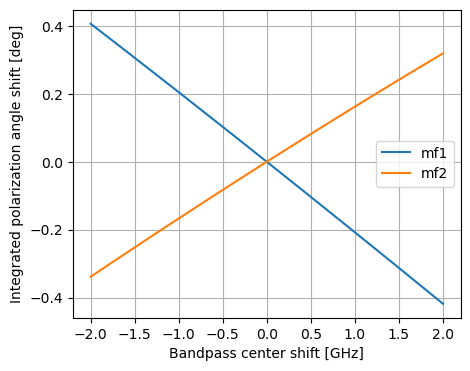

In [9]:
plt.figure(figsize=(5, 4))
plt.plot(bandpass_center_shifts, mf1_pol_angle_shifts, label='mf1')
plt.plot(bandpass_center_shifts, mf2_pol_angle_shifts, label='mf2')
plt.legend()
plt.xlabel('Bandpass center shift [GHz]')
plt.ylabel('Integrated polarization angle shift [deg]')
plt.show()

Check with with back of the envelope estimation:



In [10]:
np.diff(phase_angle_variation_function([115, 75]))

array([7.92867843])

=> We get a total phase angle variation of roughly 8 degrees over ~30GHz for
each passband, which is roughly .25 deg per GHz. So, if the band center shifts
by 1GHz this means that the integrated phase angle will shift by ~.25 degrees
(roughly accurate here)



### Other types of phase angle variation



We can additionally compute the effects of other types of phase variation. For
instance, a four-layer half-wave plate design ideally contributes near-zero
phase variation over a passband but given tolerancing of the layer thickness
and angles in practice is expected to yield not more than 0.25 degrees
variation in the 90GHz band and 0.5 degrees in the 150 GHz band. We can quickly
see how much these would affect the polarization angle:



In [11]:
step_mf1 = 0.0062
step_mf2 = 0.0083
# start the variation arbitrarily at 20 degrees
lin_phases_mf1 = np.linspace(20, 20 + step_mf1 * len(freqs), len(freqs))
lin_phases_mf2 = np.linspace(20, 20 + step_mf2 * len(freqs), len(freqs))
lin_phase_angle_variation_function_mf1 = interp1d(freqs, lin_phases_mf1)
lin_phase_angle_variation_function_mf2 = interp1d(freqs, lin_phases_mf2)
print(np.diff(lin_phase_angle_variation_function_mf1([75, 115])))
print(np.diff(lin_phase_angle_variation_function_mf2([120, 180])))

[0.24978417]
[0.50158273]


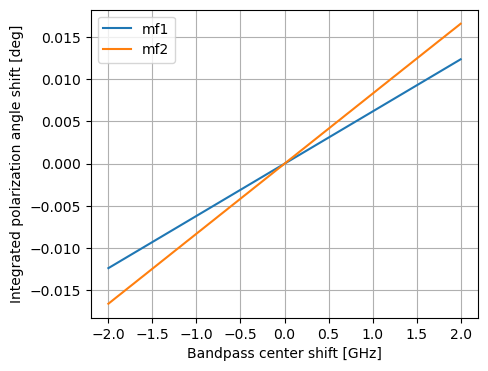

In [12]:
integration_freqs = np.linspace(65, 195, 1000) # in GHz
bandpass_center_shifts = np.linspace(-2, 2, 100) # in GHz

mf1_pol_angle_shifts = [propagate_center_uncertainty(
    delta, mf1_band_response_function, lin_phase_angle_variation_function_mf1,
    integration_freqs) for delta in bandpass_center_shifts]

mf2_pol_angle_shifts = [propagate_center_uncertainty(
    delta, mf2_band_response_function, lin_phase_angle_variation_function_mf2,
    integration_freqs) for delta in bandpass_center_shifts]

plt.figure(figsize=(5, 4))
plt.plot(bandpass_center_shifts, mf1_pol_angle_shifts, label='mf1')
plt.plot(bandpass_center_shifts, mf2_pol_angle_shifts, label='mf2')
plt.legend()
plt.xlabel('Bandpass center shift [GHz]')
plt.ylabel('Integrated polarization angle shift [deg]')
plt.show()